In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Subset, random_split
import matplotlib.pyplot as plt
import numpy as np

# Configuración general
SEED = 42
BATCH_SIZE = 1024
VAL_SPLIT = 0.2

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")


Usando dispositivo: cuda


In [2]:
# Transformaciones de MNIST: convertir a tensor y normalizar
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # media y std de MNIST
])

In [3]:
# Cargar datasets MNIST completos (todas las clases 0–9)
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.13MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 243kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.50MB/s]


In [4]:
# Dividir el train en entrenamiento y validación (80/20)
from torch.utils.data import random_split

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_data, val_data = random_split(train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

# Crear los data loaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


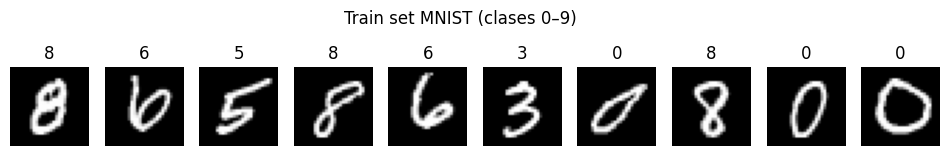

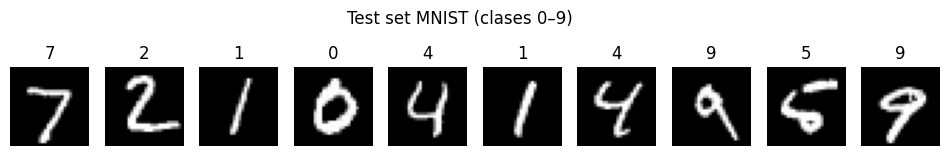

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def show_mnist_batch(data_loader, title="Ejemplos del dataset MNIST", num_images=10):
    images_shown = 0
    plt.figure(figsize=(12, 2))
    for images, labels in data_loader:
        for img, label in zip(images, labels):
            if images_shown >= num_images:
                break
            plt.subplot(1, num_images, images_shown + 1)
            plt.imshow(img.squeeze(), cmap='gray')
            plt.title(str(label.item()))
            plt.axis('off')
            images_shown += 1
        break  # Solo una tanda (primer batch)
    plt.suptitle(title)
    plt.show()

show_mnist_batch(train_loader, title="Train set MNIST (clases 0–9)")
show_mnist_batch(test_loader, title="Test set MNIST (clases 0–9)")


In [6]:
import torch.nn as nn
import torch.optim as optim

# Definir modelo para 10 clases
class AlexNetMNIST(nn.Module):
    def __init__(self):
        super(AlexNetMNIST, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 3 * 3, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 10)  # ← Salida para 10 clases
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 3 * 3)
        x = self.classifier(x)
        return x

# Instanciar modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNetMNIST().to(device)

# Definir criterio y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Confirmar detalles
print(f"Modelo en dispositivo: {next(model.parameters()).device}")
print(f"Número total de parámetros: {sum(p.numel() for p in model.parameters())}")


Modelo en dispositivo: cuda:0
Número total de parámetros: 5140682


In [7]:
# Entrenamiento
from tqdm import tqdm

EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Época {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / total
    train_acc = 100 * correct / total

    # Validación
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= val_total
    val_acc = 100 * val_correct / val_total

    print(f"\nÉpoca {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")


Época 1/10: 100%|██████████| 47/47 [00:17<00:00,  2.66it/s]



Época 1/10
Train Loss: 0.8584 | Train Acc: 70.23%
Val Loss:   0.1414 | Val Acc:   95.86%


Época 2/10: 100%|██████████| 47/47 [00:16<00:00,  2.80it/s]



Época 2/10
Train Loss: 0.1054 | Train Acc: 96.82%
Val Loss:   0.0630 | Val Acc:   97.97%


Época 3/10: 100%|██████████| 47/47 [00:17<00:00,  2.73it/s]



Época 3/10
Train Loss: 0.0610 | Train Acc: 98.18%
Val Loss:   0.0488 | Val Acc:   98.45%


Época 4/10: 100%|██████████| 47/47 [00:21<00:00,  2.19it/s]



Época 4/10
Train Loss: 0.0434 | Train Acc: 98.64%
Val Loss:   0.0370 | Val Acc:   98.82%


Época 5/10: 100%|██████████| 47/47 [00:17<00:00,  2.76it/s]



Época 5/10
Train Loss: 0.0369 | Train Acc: 98.84%
Val Loss:   0.0359 | Val Acc:   99.02%


Época 6/10: 100%|██████████| 47/47 [00:17<00:00,  2.73it/s]



Época 6/10
Train Loss: 0.0267 | Train Acc: 99.17%
Val Loss:   0.0329 | Val Acc:   99.06%


Época 7/10: 100%|██████████| 47/47 [00:16<00:00,  2.78it/s]



Época 7/10
Train Loss: 0.0272 | Train Acc: 99.19%
Val Loss:   0.0331 | Val Acc:   99.08%


Época 8/10: 100%|██████████| 47/47 [00:17<00:00,  2.75it/s]



Época 8/10
Train Loss: 0.0192 | Train Acc: 99.40%
Val Loss:   0.0302 | Val Acc:   99.08%


Época 9/10: 100%|██████████| 47/47 [00:17<00:00,  2.73it/s]



Época 9/10
Train Loss: 0.0178 | Train Acc: 99.46%
Val Loss:   0.0325 | Val Acc:   99.09%


Época 10/10: 100%|██████████| 47/47 [00:16<00:00,  2.80it/s]



Época 10/10
Train Loss: 0.0158 | Train Acc: 99.53%
Val Loss:   0.0352 | Val Acc:   99.06%


In [8]:
# Guardamos pesos del modelo entrenado (AlexNetMNIST).
torch.save(model.state_dict(), "modelo_mnist.pth")

In [9]:
# Cargamos los pesos y verificamos que las capas correspondan a la variable alexnet_model.
alexnet_model = AlexNetMNIST().to(device)
alexnet_model.load_state_dict(torch.load("modelo_mnist.pth"))
alexnet_model.eval()

AlexNetMNIST(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=2304, out_features=1024, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.

In [10]:
# Modelo2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Capa 1
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Capa 2
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Capa 3
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),  # Capa 4
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # Capa 5
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 3 * 3, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# Asegurar uso de GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Instanciar el modelo
model2 = Model2().to(device)

# Definir función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

Usando dispositivo: cuda


In [12]:
# Entrenamiento Modelo2
epochs = 10

for epoch in range(epochs):
    model2.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100 * correct / total

    # Validación
    model2.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model2(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = 100 * val_correct / val_total

    print(f"\nÉpoca {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")



Época 1/10
Train Loss: 0.0426 | Train Acc: 98.68%
Val Loss:   0.0508 | Val Acc:   98.41%

Época 2/10
Train Loss: 0.0341 | Train Acc: 98.93%
Val Loss:   0.0406 | Val Acc:   98.78%

Época 3/10
Train Loss: 0.0248 | Train Acc: 99.17%
Val Loss:   0.0354 | Val Acc:   98.97%

Época 4/10
Train Loss: 0.0212 | Train Acc: 99.33%
Val Loss:   0.0379 | Val Acc:   98.92%

Época 5/10
Train Loss: 0.0151 | Train Acc: 99.52%
Val Loss:   0.0364 | Val Acc:   98.93%

Época 6/10
Train Loss: 0.0105 | Train Acc: 99.69%
Val Loss:   0.0388 | Val Acc:   98.88%

Época 7/10
Train Loss: 0.0130 | Train Acc: 99.55%
Val Loss:   0.0411 | Val Acc:   98.82%

Época 8/10
Train Loss: 0.0122 | Train Acc: 99.57%
Val Loss:   0.0353 | Val Acc:   99.09%

Época 9/10
Train Loss: 0.0080 | Train Acc: 99.73%
Val Loss:   0.0372 | Val Acc:   99.00%

Época 10/10
Train Loss: 0.0058 | Train Acc: 99.83%
Val Loss:   0.0370 | Val Acc:   99.08%


In [13]:
# Modelo3
import torch.nn as nn

class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),              # Convierte (1, 28, 28) → (784)
            nn.Linear(784, 512),       # Capa 1
            nn.ReLU(),
            nn.Linear(512, 256),       # Capa 2
            nn.ReLU(),
            nn.Linear(256, 128),       # Capa 3
            nn.ReLU(),
            nn.Linear(128, 64),        # Capa 4
            nn.ReLU(),
            nn.Linear(64, 10)          # Capa 5 (salida para 10 clases)
        )

    def forward(self, x):
        return self.model(x)

# Asegurar uso de GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Instanciar el modelo
model3 = Model3().to(device)

# Definir función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001)


Usando dispositivo: cuda


In [14]:
# Entrenamiento Modelo3
epochs = 10

for epoch in range(epochs):
    model3.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model3(images)  # <--- se usa model3
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100 * correct / total

    # Validación
    model3.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model3(images)  # <--- se usa model3
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = 100 * val_correct / val_total

    print(f"\nÉpoca {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")



Época 1/10
Train Loss: 0.7968 | Train Acc: 76.33%
Val Loss:   0.3426 | Val Acc:   89.88%

Época 2/10
Train Loss: 0.2487 | Train Acc: 92.49%
Val Loss:   0.2210 | Val Acc:   93.47%

Época 3/10
Train Loss: 0.1680 | Train Acc: 95.02%
Val Loss:   0.1659 | Val Acc:   95.13%

Época 4/10
Train Loss: 0.1291 | Train Acc: 96.14%
Val Loss:   0.1431 | Val Acc:   95.81%

Época 5/10
Train Loss: 0.0987 | Train Acc: 97.04%
Val Loss:   0.1227 | Val Acc:   96.38%

Época 6/10
Train Loss: 0.0772 | Train Acc: 97.63%
Val Loss:   0.1070 | Val Acc:   96.76%

Época 7/10
Train Loss: 0.0609 | Train Acc: 98.15%
Val Loss:   0.1027 | Val Acc:   96.92%

Época 8/10
Train Loss: 0.0475 | Train Acc: 98.59%
Val Loss:   0.0968 | Val Acc:   97.16%

Época 9/10
Train Loss: 0.0403 | Train Acc: 98.80%
Val Loss:   0.0999 | Val Acc:   96.98%

Época 10/10
Train Loss: 0.0337 | Train Acc: 98.98%
Val Loss:   0.0929 | Val Acc:   97.38%


In [23]:
# Preprocesamiento de dataset, para la arquitectura origianl Alexnet (224x224).
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split

# Transformar a 3 canales + resize a 224x224
alexnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # de 1 canal a 3
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # 3 canales
])

# Dataset completo
train_dataset_alexnet = MNIST(root='./data', train=True, download=True, transform=alexnet_transform)
test_dataset_alexnet = MNIST(root='./data', train=False, download=True, transform=alexnet_transform)

# Dividir en entrenamiento y validación
train_size = int(0.8 * len(train_dataset_alexnet))
val_size = len(train_dataset_alexnet) - train_size
train_data_alexnet, val_data_alexnet = random_split(train_dataset_alexnet, [train_size, val_size])

# Data loaders
train_loader_alexnet = DataLoader(train_data_alexnet, batch_size=64, shuffle=True)
val_loader_alexnet   = DataLoader(val_data_alexnet, batch_size=64, shuffle=False)
test_loader_alexnet  = DataLoader(test_dataset_alexnet, batch_size=64, shuffle=False)


In [24]:
import torch.nn as nn

class AlexNetMNISTOriginal(nn.Module):
    def __init__(self):
        super(AlexNetMNISTOriginal, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),   # in_channels=3
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),  # para imagen 224x224
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10)  # 10 clases para MNIST
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x


In [25]:
# Entrenamiento
alexnet_original = AlexNetMNISTOriginal().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(alexnet_original.parameters(), lr=0.001)

EPOCHS = 10

for epoch in range(EPOCHS):
    alexnet_original.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader_alexnet, desc=f"Época {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = alexnet_original(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    avg_train_loss = train_loss / total

    # Validación
    alexnet_original.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader_alexnet:
            images, labels = images.to(device), labels.to(device)
            outputs = alexnet_original(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    avg_val_loss = val_loss / val_total

    print(f"\nÉpoca {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss:   {avg_val_loss:.4f} | Val Acc:   {val_acc:.2f}%")


Época 1/10: 100%|██████████| 750/750 [02:12<00:00,  5.64it/s]



Época 1/10
Train Loss: 0.3054 | Train Acc: 89.83%
Val Loss:   0.0691 | Val Acc:   97.88%


Época 2/10: 100%|██████████| 750/750 [02:15<00:00,  5.52it/s]



Época 2/10
Train Loss: 0.0991 | Train Acc: 97.12%
Val Loss:   0.0622 | Val Acc:   98.22%


Época 3/10: 100%|██████████| 750/750 [02:12<00:00,  5.67it/s]



Época 3/10
Train Loss: 0.0950 | Train Acc: 97.39%
Val Loss:   0.0566 | Val Acc:   98.24%


Época 4/10: 100%|██████████| 750/750 [02:16<00:00,  5.51it/s]



Época 4/10
Train Loss: 0.0790 | Train Acc: 97.87%
Val Loss:   0.0522 | Val Acc:   98.62%


Época 5/10: 100%|██████████| 750/750 [02:09<00:00,  5.81it/s]



Época 5/10
Train Loss: 0.0736 | Train Acc: 97.97%
Val Loss:   0.0542 | Val Acc:   98.69%


Época 6/10: 100%|██████████| 750/750 [02:09<00:00,  5.77it/s]



Época 6/10
Train Loss: 0.0746 | Train Acc: 98.10%
Val Loss:   0.0400 | Val Acc:   98.84%


Época 7/10: 100%|██████████| 750/750 [02:13<00:00,  5.60it/s]



Época 7/10
Train Loss: 0.0636 | Train Acc: 98.22%
Val Loss:   0.0552 | Val Acc:   98.58%


Época 8/10: 100%|██████████| 750/750 [02:15<00:00,  5.55it/s]



Época 8/10
Train Loss: 0.0681 | Train Acc: 98.20%
Val Loss:   0.0467 | Val Acc:   98.84%


Época 9/10: 100%|██████████| 750/750 [02:11<00:00,  5.71it/s]



Época 9/10
Train Loss: 0.0617 | Train Acc: 98.35%
Val Loss:   0.0485 | Val Acc:   98.81%


Época 10/10: 100%|██████████| 750/750 [02:09<00:00,  5.81it/s]



Época 10/10
Train Loss: 0.0797 | Train Acc: 98.04%
Val Loss:   0.0412 | Val Acc:   98.93%


In [29]:
# Verificar que las variables corresponden a la clase (model) correspondiente.
print(type(alexnet_model))
print(type(model2))
print(type(model3))
print(type(alexnet_original))

<class '__main__.AlexNetMNIST'>
<class '__main__.Model2'>
<class '__main__.Model3'>
<class '__main__.AlexNetMNISTOriginal'>


In [35]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split

# Transformación para MNIST (mantener 1 canal y 28x28)
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Media y desviación estándar de MNIST
])

# Dataset completo
train_dataset = MNIST(root='./data', train=True, download=True, transform=mnist_transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=mnist_transform)

# Dividir en entrenamiento y validación
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)


Comparando modelos...
Evaluando AlexNet...
Evaluando Modelo 2...
Evaluando Modelo 3...

RESUMEN COMPARATIVO DE MODELOS
Modelo          Accuracy     Precision    Recall       F1-Score    
-------------------------------------------------------------------------------------
AlexNet         0.992700     0.992746     0.992700     0.992695    
Modelo 2        0.991600     0.991625     0.991600     0.991590    
Modelo 3        0.977000     0.977040     0.977000     0.976984    


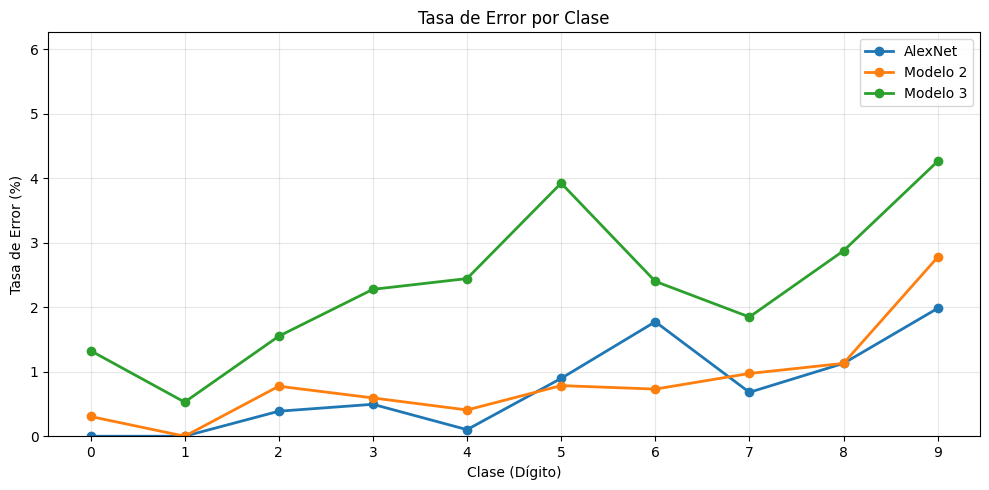

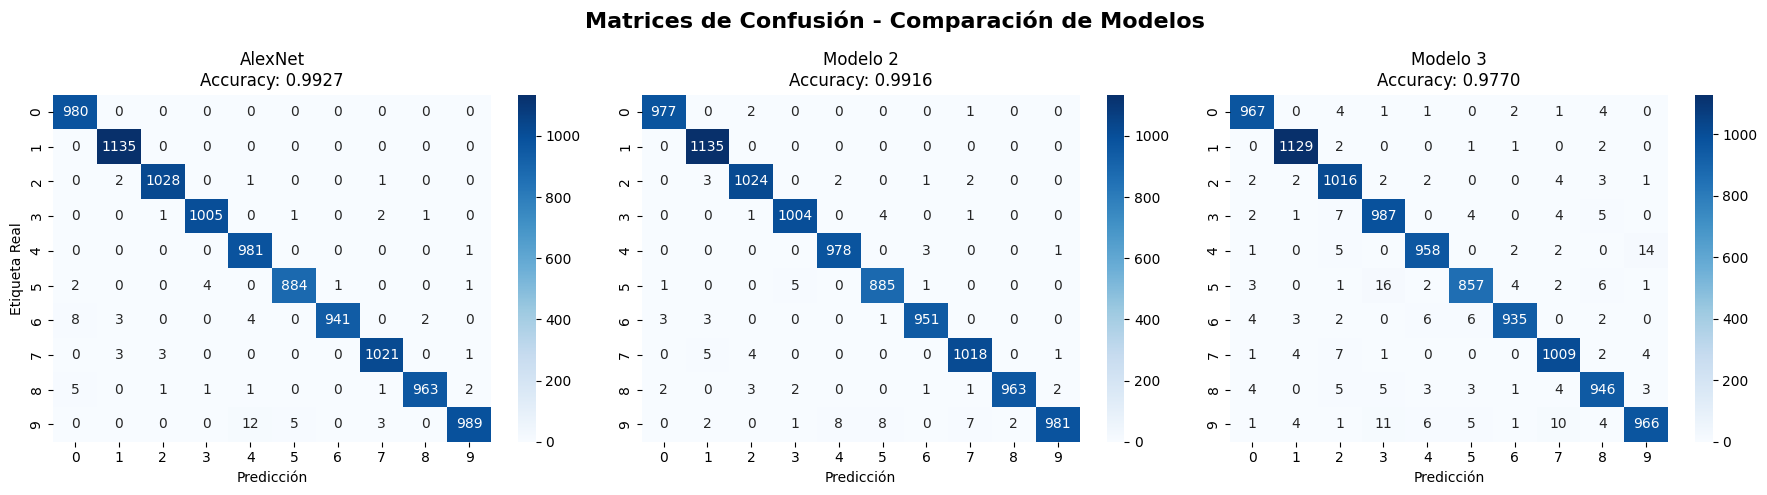


MEJOR MODELO:
   AlexNet con 0.992700 de accuracy

DIFERENCIAS:
   Rango de accuracy: 0.977000 - 0.992700
   Diferencia: 1.570 puntos porcentuales


In [36]:
# Resultados de comparativa y evaluacion de modelos (Alexnet usando un solo canal con modelos 2 y 3).
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

def evaluate_model_simple(model, test_loader, device, model_name):
    """
    Evaluación simple de un modelo
    """
    model.eval()
    all_preds = []
    all_labels = []

    print(f"Evaluando {model_name}...")

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calcular métricas
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, support = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted'
    )
    cm = confusion_matrix(all_labels, all_preds)

    return {
        'name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': all_preds,
        'labels': all_labels,
        'confusion_matrix': cm
    }

def compare_models_simple(model1, model2, model3, test_loader, device,
                         names=['AlexNet', 'Modelo 2', 'Modelo 3']):
    """
    Comparación simple de tres modelos
    """
    print("Comparando modelos...")
    print("="*50)

    # Evaluar cada modelo
    results = []
    models = [model1, model2, model3]

    for model, name in zip(models, names):
        result = evaluate_model_simple(model, test_loader, device, name)
        results.append(result)

    # 1. RESUMEN COMPARATIVO
    print("\n" + "="*85)
    print("RESUMEN COMPARATIVO DE MODELOS")
    print("="*85)

    print(f"{'Modelo':<15} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
    print("-" * 85)

    for result in results:
        print(f"{result['name']:<15} "
              f"{result['accuracy']:<12.6f} "
              f"{result['precision']:<12.6f} "
              f"{result['recall']:<12.6f} "
              f"{result['f1']:<12.6f}")

    # 2. TASA DE ERROR POR CLASE
    plt.figure(figsize=(10, 5))
    classes = list(range(10))
    all_error_rates = []

    for result in results:
        cm = result['confusion_matrix']
        error_rates = []

        for class_idx in range(10):
            total_class = cm[class_idx].sum()
            correct_class = cm[class_idx, class_idx]
            error_rate = (total_class - correct_class) / total_class if total_class > 0 else 0
            error_rates.append(error_rate * 100)  # Convertir a porcentaje

        all_error_rates.extend(error_rates)
        plt.plot(classes, error_rates, marker='o', label=result['name'],
                linewidth=2, markersize=6)

    plt.xlabel('Clase (Dígito)')
    plt.ylabel('Tasa de Error (%)')
    plt.title('Tasa de Error por Clase')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(classes)
    if all_error_rates:
        plt.ylim(0, max(all_error_rates) + 2)
    else:
        plt.ylim(0, 10)

    plt.tight_layout()
    plt.show()

    # 3. MATRICES DE CONFUSIÓN
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Matrices de Confusión - Comparación de Modelos', fontsize=16, fontweight='bold')

    classes = [str(i) for i in range(10)]

    for i, result in enumerate(results):
        cm = result['confusion_matrix']

        # Crear heatmap
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                   xticklabels=classes, yticklabels=classes,
                   ax=axes[i], cbar=True)

        axes[i].set_title(f"{result['name']}\nAccuracy: {result['accuracy']:.4f}")
        axes[i].set_xlabel("Predicción")

        if i == 0:  # Solo el primer gráfico tiene ylabel
            axes[i].set_ylabel("Etiqueta Real")

    plt.tight_layout()
    plt.show()

    # Análisis adicional
    print(f"\nMEJOR MODELO:")
    best_model = max(results, key=lambda x: x['accuracy'])
    print(f"   {best_model['name']} con {best_model['accuracy']:.6f} de accuracy")

    print(f"\nDIFERENCIAS:")
    accuracies_vals = [r['accuracy'] for r in results]
    best_acc = max(accuracies_vals)
    worst_acc = min(accuracies_vals)
    print(f"   Rango de accuracy: {worst_acc:.6f} - {best_acc:.6f}")
    print(f"   Diferencia: {(best_acc - worst_acc)*100:.3f} puntos porcentuales")

    return results

# Ejecutar la comparación simplificada
model_names = ['AlexNet', 'Modelo 2', 'Modelo 3']  # Cambia estos nombres
results = compare_models_simple(
    alexnet_model, model2, model3,
    test_loader, device, model_names
)